In [2]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from PIL import Image
import random
from sklearn.cross_validation import train_test_split
from tqdm import tnrange

In [3]:
resize_default=64

def resizeImg(image):
    img_w=image.size[0]
    img_h=image.size[1]
    #print("Image: %s (%i x %i)" % (imgUrl, img_w, img_h))
    slot = int(img_w/100) +1 if img_w > img_h else int(img_h/100) +1 
    
    if slot!=0:
        if img_w >= img_h:
            img = image.resize((resize_default,int(resize_default*img_h/img_w)), Image.ANTIALIAS)
        else:
            img = image.resize((int(resize_default*img_w/img_h),resize_default), Image.ANTIALIAS)
        
    return img;

def padImg(image):
    img_w=image.size[0]
    img_h=image.size[1]
    
    if img_w > resize_default or img_h > resize_default:
        if img_w >= img_h:
            new_size = (img_w, img_w)
        else:
            new_size = (img_h, img_h)
    else:
        new_size = (resize_default, resize_default)
        
    img = Image.new("RGB", new_size)
    img.paste(image, (int((new_size[0]-img_w)/2),int((new_size[1]-img_h)/2)))
        
    return img;

In [4]:
def dropout(x, prob, train_phase):
    return tf.cond(train_phase, 
                   lambda: tf.nn.dropout(x, prob),
                   lambda: x)

def weight_variable(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
  return tf.Variable(tf.constant(0.1, shape=shape))

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

In [5]:
sess = tf.InteractiveSession()

# tf Graph Input
x = tf.placeholder(tf.float32, [None,64,64,3]) 
y = tf.placeholder(tf.float32, [None, 2])

# dropout placeholder
keep_prob = tf.placeholder(tf.float32)

# train flag placeholder
train_phase = tf.placeholder(tf.bool) # For Batch Normalization

# Set model weights
W1 = weight_variable([3, 3, 3, 32])
b1 = bias_variable([32])

W2 = weight_variable([3, 3, 32, 64])
b2 = bias_variable([64])

W3 = weight_variable([3, 3, 64, 64])
b3 = bias_variable([64])

W4 = weight_variable([16 * 16 * 64, 512])
b4 = bias_variable([512])

W5 = weight_variable([512, 2])
b5 = bias_variable([2])

# hidden layers
conv1 = tf.nn.relu(conv2d(x, W1) + b1)
maxp1 = max_pool_2x2(conv1)

conv2 = tf.nn.relu(conv2d(maxp1, W2) + b2)
#maxp2 = max_pool_2x2(conv2)

conv3 = tf.nn.relu(conv2d(conv2, W3) + b3)
maxp3 = max_pool_2x2(conv3)

# fully connected
maxp3_flat = tf.reshape(maxp3, [-1, 16 * 16 * 64])

full1 = tf.nn.relu(tf.matmul(maxp3_flat, W4) + b4)
drop1 = tf.nn.dropout(full1, keep_prob)

#output
output = tf.matmul(drop1, W5) + b5
softmax=tf.nn.softmax(output)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, y))

all_variables = tf.trainable_variables() 

In [6]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
saver.restore(sess, "./saved/model2.ckpt")
print("Model restored...")

Model restored...


Predicted: Cat


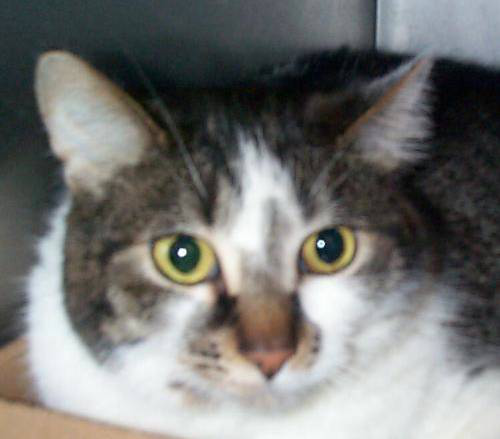

In [23]:
train_path = "data/test1"
X_test = glob.glob(os.path.join(train_path, "*.jpg"))

y=tf.nn.softmax(output)
test_img = Image.open(X_test[int(np.random.uniform(0, len(X_test)))])

input_array = np.array(padImg(resizeImg(test_img))).reshape([-1]) / 255
input_array = input_array.reshape([-1,64,64,3])

softmax=tf.nn.softmax(output)
prediction = sess.run(tf.argmax(y, 1), feed_dict={x: input_array, train_phase: False, keep_prob: 1.0})
print("Predicted: " + ("Cat" if prediction[0]==0 else "Dog"))
test_img